In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer

import numpy as np
import os
import time

corpus_path = '../gutenberg_ebooks/'
text = ""
count = 0
for filename in os.listdir(corpus_path):
    if filename.endswith(".txt") and ("Aristotle" in filename or "Plato" in filename or "Homer" in filename):
        with open(os.path.join(corpus_path, filename), 'r', encoding='utf-8', errors='ignore') as f:
            text += f.read().lower()
            print(filename)

2025-06-08 10:48:26.043177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749390506.072496  194450 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749390506.077104  194450 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749390506.129722  194450 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749390506.129747  194450 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749390506.129751  194450 computation_placer.cc:177] computation placer alr

Homer_-_The_Iliad.txt
Homer_-_The_Odyssey.txt
Plato_-_Charmides.txt
Plato_-_Lysis.txt
Plato_-_Laches.txt
Plato_-_Protagoras.txt
Plato_-_Euthydemus.txt
Plato_-_Cratylus.txt
Plato_-_Phaedrus.txt
Plato_-_Ion.txt
Plato_-_Symposium.txt
Plato_-_Meno.txt
Plato_-_Euthyphro.txt
Plato_-_Apology.txt
Plato_-_Crito.txt
Plato_-_Phaedo.txt
Plato_-_Gorgias.txt
Plato_-_The_Republic.txt
Plato_-_Timaeus.txt
Plato_-_Critias.txt
Plato_-_Parmenides.txt
Plato_-_Theaetetus.txt
Plato_-_Sophist.txt
Plato_-_Statesman.txt
Plato_-_Philebus.txt
Plato_-_Laws.txt
Aristotle_-_Categories.txt
Aristotle_-_Physics.txt
Aristotle_-_On_the_Heavens.txt
Aristotle_-_On_Dreams.txt
Aristotle_-_History_of_Animals.txt
Aristotle_-_Politics.txt
Aristotle_-_The_Athenian_Constitution.txt
Aristotle_-_Rhetoric.txt
Aristotle_-_Poetics.txt
Aristotle_-_On_the_Soul.txt
Aristotle_-_Nicomachean_Ethics.txt


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Arquitectura simple: Emb -> LSTM -> Dense

## Tokenizacion por caracter

In [ ]:
def build_char_sliding_windows(text, seq_length = 100, step = 1):
    chars = sorted(list(set(text)))
    char_to_int = {char: i for i, char in enumerate(chars)}
    int_to_char = {i: char for i, char in enumerate(chars)}
    vocab_size = len(chars)
    int_text = np.array([char_to_int[c] for c in text])
    
    sequences = []
    next_chars = []
    
    for i in range(0, len(int_text) - seq_length, step):
        sequences.append(int_text[i: i + seq_length])
        next_chars.append(int_text[i + seq_length])
    
    x = np.array(sequences)
    y = np.array(next_chars)
    
    return window, target, vocab_size
    
x, y, vocab_size = build_sliding_windows(text)

embedding_dim = 64
rnn_units = 128

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.LSTM(rnn_units, return_sequences=False),
    layers.Dense(vocab_size, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 20
batch_size = 128

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 64)        │        12,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 199)            │        25,671 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,223 (536.03 KB)

 Trainable params: 137,223 (536.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
)

model_save_path = './text_generation_rnn_model.keras'
model.save(model_save_path)
# model = tf.keras.models.load_model('./text_generation_rnn_model.keras')

In [78]:
def generate_text(model, start_string, num_generate=500, temperature=1.0):
    start_string_lower = start_string.lower()

    history = [0] * seq_length
    start_as_ints = [char_to_int.get(s, 0) for s in start_string_lower]

    if len(start_as_ints) >= seq_length:
        history = start_as_ints[-seq_length:]
    else:
        history[-len(start_as_ints):] = start_as_ints
    
    input_eval = tf.expand_dims(history, 0)

    text_generated = []
    # model.reset_state()

    for i in range(num_generate):
        predictions_from_model = model(input_eval)
        
        scaled_logits = predictions_from_model / temperature
        predicted_id_tensor = tf.random.categorical(scaled_logits, num_samples=1)
        predicted_id = predicted_id_tensor[0, 0].numpy()
        # predicted_id = np.argsort(scaled_logits.numpy().flatten())[-1]
        predicted_char = int_to_char.get(predicted_id, '?')
        text_generated.append(predicted_char)
        
        history.append(predicted_id)
        history = history[1:]
        
        input_eval = tf.expand_dims(history, 0)

    return (start_string + ''.join(text_generated))

if len(sequences) > 0:
    seed_text = "It was a dark and stormy night"
    generated_output_temp_0_5 = generate_text(model, start_string=seed_text, num_generate=500, temperature=0.5)
    # To see the output, you would need to print it:
    print(f"\nTemperature 0.5:\n{generated_output_temp_0_5}")

    generated_output_temp_1_0 = generate_text(model, start_string=seed_text, num_generate=500, temperature=1.0)
    print(f"\nTemperature 1.0:\n{generated_output_temp_1_0}")

    generated_output_temp_1_5 = generate_text(model, start_string="The king declared", num_generate=500, temperature=1.2)
    print(f"\nTemperature 1.2 (different seed):\n{generated_output_temp_1_5}")

NameError: name 'sequences' is not defined

No dio muy bien.


## Tokenizacion por palabra

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
def build_word_sliding_windows(text_corpus, seq_length = 10, step = 1):
    
    tokenizer = Tokenizer(oov_token="<unk>", num_words=5000)
    tokenizer.fit_on_texts([text_corpus])
    
    word_to_int = tokenizer.word_index
    int_to_word = tokenizer.index_word
    # vocab_size = len(word_to_int) + 1
    vocab_size = 5000 + 1
    
    int_text_tokens = tokenizer.texts_to_sequences([text_corpus])[0]
    
    sequences = []
    next_words = []
    
    for i in range(0, len(int_text_tokens) - seq_length, step):
        sequences.append(int_text_tokens[i: i + seq_length])
        next_words.append(int_text_tokens[i + seq_length])
    
    if not sequences:
        exit()
    
    x = np.array(sequences)
    y = np.array(next_words)
    
    return x, y, vocab_size

    

In [52]:
tokenizer = Tokenizer(oov_token="<unk>", num_words=5000)
tokenizer.fit_on_texts([text])

word_to_int = tokenizer.word_index
int_to_word = tokenizer.index_word
vocab_size = len(word_to_int) + 1

int_text_tokens = tokenizer.texts_to_sequences([text])[0]

In [48]:
vocab_size

51227

[2.00000e+00 5.12440e+03 1.02468e+04 1.53692e+04 2.04916e+04 2.56140e+04
 3.07364e+04 3.58588e+04 4.09812e+04 4.61036e+04 5.12260e+04]


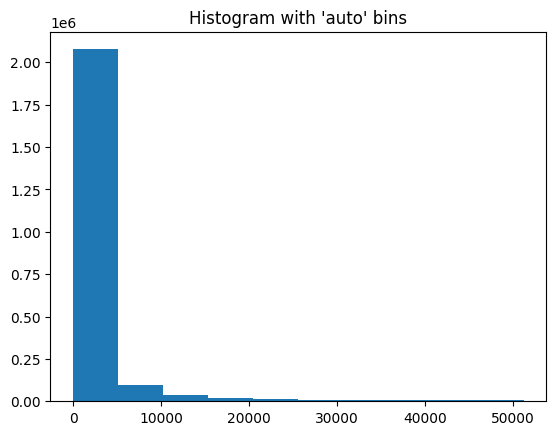

In [39]:
import matplotlib.pyplot as plt
import numpy as np
hist, edges = np.histogram(int_text_tokens)
print(edges)
plt.hist(int_text_tokens, bins=edges)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [86]:
x, y, vocab_size = build_word_sliding_windows(text)

embedding_dim = 256
rnn_units = 128

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.LSTM(rnn_units, return_sequences=False),
    layers.Dense(vocab_size, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 90
batch_size = 1024

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)


Epoch 1/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.1290 - loss: 5.7916 - val_accuracy: 0.2155 - val_loss: 5.0395
Epoch 2/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.2055 - loss: 4.7689 - val_accuracy: 0.2233 - val_loss: 4.8716
Epoch 3/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.2273 - loss: 4.5146 - val_accuracy: 0.2315 - val_loss: 4.7641
Epoch 4/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.2441 - loss: 4.3588 - val_accuracy: 0.2347 - val_loss: 4.6837
Epoch 5/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.2551 - loss: 4.2547 - val_accuracy: 0.2391 - val_loss: 4.6163
Epoch 6/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.2618 - loss: 4.1769 - val_accuracy: 0.2420 - val_loss: 4.5482
Epoch 7/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.2674 - loss: 4.1124 - val_accuracy: 0.2466 - val_loss: 4.4979
Epoch 8/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.2719 -

In [87]:
model_save_path = './word_sa_lr01.keras'
# model.save(model_save_path)

In [82]:
seed_text = "It was a dark and stormy night"
generated_output_temp_0_5 = generate_text(model, start_string=seed_text, num_generate=20, temperature=0.5)
# To see the output, you would need to print it:
print(f"\nTemperature 0.5:\n{generated_output_temp_0_5}")

generated_output_temp_1_0 = generate_text(model, start_string=seed_text, num_generate=20, temperature=1.0)
print(f"\nTemperature 1.0:\n{generated_output_temp_1_0}")

generated_output_temp_1_5 = generate_text(model, start_string="The king declared", num_generate=20, temperature=1.2)
print(f"\nTemperature 1.2 (different seed):\n{generated_output_temp_1_5}")


Temperature 0.5:
It was a dark and stormy night daring nourished readable execution helen euthydemus obtaining numerous outward obscure arrow satisfactory notes brazen oft 18 woman's exercises agreement attend

Temperature 1.0:
It was a dark and stormy night twelve multitude transcribe question chaerephon they analogy sees μέσα poets attached affirmed wanted δηλαδή x ctesippus plain aware bare scale

Temperature 1.2 (different seed):
The king declared majority roll’d do go anxious hymn file laches holder suddenly οποίαν answered allows assigned touch’d conquered love appeared saved beasts


In [96]:
# Duplicamos la capa LSTM
x, y, vocab_size = build_word_sliding_windows(text)

embedding_dim = 256
rnn_units = 128

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.LSTM(rnn_units, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(rnn_units, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(vocab_size, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 90
batch_size = 1024 + 512

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)


Epoch 1/90
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.0951 - loss: 6.1280 - val_accuracy: 0.1943 - val_loss: 5.3511
Epoch 2/90
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.1690 - loss: 5.2387 - val_accuracy: 0.2126 - val_loss: 5.0599
Epoch 3/90
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.1901 - loss: 4.9198 - val_accuracy: 0.2186 - val_loss: 4.9587
Epoch 4/90
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.2033 - loss: 4.7383 - val_accuracy: 0.2218 - val_loss: 4.8891
Epoch 5/90
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.2160 - loss: 4.6185 - val_accuracy: 0.2247 - val_loss: 4.8300
Epoch 6/90
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.2257 - loss: 4.5299 - val_accuracy: 0.2284 - val_loss: 4.7652
Epoch 7/90
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.2341 - loss: 4.4594 - val_accuracy: 0.2322 - val_loss: 4.7163
Epoch 8/90
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.2397 -

In [97]:


model_save_path = './word_sa_lr01-2.keras'
model.save(model_save_path)

In [98]:
x, y, vocab_size = build_word_sliding_windows(text)

embedding_dim = 256
rnn_units = 256

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.LSTM(rnn_units, return_sequences=False),
    layers.Dense(vocab_size, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 90
batch_size = 2048

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)


Epoch 1/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.1255 - loss: 5.8545 - val_accuracy: 0.2116 - val_loss: 5.0750
Epoch 2/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.1991 - loss: 4.8335 - val_accuracy: 0.2189 - val_loss: 4.9089
Epoch 3/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.2192 - loss: 4.5651 - val_accuracy: 0.2256 - val_loss: 4.7865
Epoch 4/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.2373 - loss: 4.3978 - val_accuracy: 0.2316 - val_loss: 4.6946
Epoch 5/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.2517 - loss: 4.2675 - val_accuracy: 0.2388 - val_loss: 4.6000
Epoch 6/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.2617 - loss: 4.1696 - val_accuracy: 0.2417 - val_loss: 4.5509
Epoch 7/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.2675 - loss: 4.0977 - val_accuracy: 0.2487 - val_loss: 4.4725
Epoch 8/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.2722 -

In [99]:
model_save_path = './word_sa_lr01-3.keras'
# model.save(model_save_path)

In [101]:
x, y, vocab_size = build_word_sliding_windows(text)

embedding_dim = 512
rnn_units = 512

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.LSTM(rnn_units, return_sequences=False),
    layers.Dense(vocab_size, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 90
batch_size = 2048

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)


Epoch 1/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - accuracy: 0.1450 - loss: 5.6014 - val_accuracy: 0.2127 - val_loss: 4.9454
Epoch 2/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - accuracy: 0.2178 - loss: 4.5896 - val_accuracy: 0.2256 - val_loss: 4.7426
Epoch 3/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2462 - loss: 4.3105 - val_accuracy: 0.2396 - val_loss: 4.5817
Epoch 4/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2626 - loss: 4.1411 - val_accuracy: 0.2471 - val_loss: 4.4767
Epoch 5/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2712 - loss: 4.0236 - val_accuracy: 0.2527 - val_loss: 4.3767
Epoch 6/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2782 - loss: 3.9232 - val_accuracy: 0.2520 - val_loss: 4.2963
Epoch 7/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2831 - loss: 3.8439 - val_accuracy: 0.2604 - val_loss: 4.2111
Epoch 8/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2886 -

In [102]:
seed_text = "It was a dark and stormy night"
generated_output_temp_0_5 = generate_text(model, start_string=seed_text, num_generate=20, temperature=0.5)
# To see the output, you would need to print it:
print(f"\nTemperature 0.5:\n{generated_output_temp_0_5}")

generated_output_temp_1_0 = generate_text(model, start_string=seed_text, num_generate=20, temperature=1.0)
print(f"\nTemperature 1.0:\n{generated_output_temp_1_0}")

generated_output_temp_1_5 = generate_text(model, start_string="The king declared", num_generate=20, temperature=1.2)
print(f"\nTemperature 1.2 (different seed):\n{generated_output_temp_1_5}")


Temperature 0.5:
It was a dark and stormy night aspects son banquet represented hopes defects flows companions reproach compared gymnastic ludicrous family is’ dwells applicable plenty sounding abstraction choose

Temperature 1.0:
It was a dark and stormy night peace service daily distinctly speeches carrying areopagus flesh thin becomes incurable selected notifies προς 2001 described employee εν belongs direction

Temperature 1.2 (different seed):
The king declared ζώον continuous enemy ridicule need science fighting harmless description fields επιστήμη οποία sufficiently sources 8 devoid existing accuracy injustice keen


In [28]:
x, y, vocab_size = build_word_sliding_windows(text);

embedding_dim = 15
rnn_units = 64 

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.LSTM(rnn_units, return_sequences=False),
    layers.Dense(vocab_size, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 30 # Adjust as needed for word-level model
batch_size = 128

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
fraction = int(x.shape[0]*0.1)

history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)

Epoch 1/30
17777/17777 ━━━━━━━━━━━━━━━━━━━━ 294s 17ms/step - accuracy: 0.1085 - loss: 6.4789 - val_accuracy: 0.1623 - val_loss: 6.2548
Epoch 2/30
17777/17777 ━━━━━━━━━━━━━━━━━━━━ 296s 17ms/step - accuracy: 0.1778 - loss: 5.4384 - val_accuracy: 0.1714 - val_loss: 6.0408
Epoch 3/30
17777/17777 ━━━━━━━━━━━━━━━━━━━━ 298s 17ms/step - accuracy: 0.2024 - loss: 5.1921 - val_accuracy: 0.1813 - val_loss: 5.9018
Epoch 4/30
17777/17777 ━━━━━━━━━━━━━━━━━━━━ 301s 17ms/step - accuracy: 0.2137 - loss: 5.0588 - val_accuracy: 0.1850 - val_loss: 5.8179
Epoch 5/30
17777/17777 ━━━━━━━━━━━━━━━━━━━━ 305s 17ms/step - accuracy: 0.2197 - loss: 4.9812 - val_accuracy: 0.1917 - val_loss: 5.7564
Epoch 6/30
17777/17777 ━━━━━━━━━━━━━━━━━━━━ 304s 17ms/step - accuracy: 0.2240 - loss: 4.9210 - val_accuracy: 0.1924 - val_loss: 5.7019
Epoch 7/30
17777/17777 ━━━━━━━━━━━━━━━━━━━━ 303s 17ms/step - accuracy: 0.2260 - loss: 4.8816 - val_accuracy: 0.1931 - val_loss: 5.6544
Epoch 8/30
17777/17777 ━━━━━━━━━━━━━━━━━━━━ 308s 17ms/s

In [29]:
model_save_path = './word_sa_lr01-03.keras'
model.save(model_save_path)

In [ ]:
x, y, vocab_size = build_word_sliding_windows(text);

embedding_dim = 15
rnn_units = 64 

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.LSTM(rnn_units, return_sequences=False),
    layers.Dense(vocab_size, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
fraction = int(x.shape[0]*0.1)

epochs = 60 # Adjust as needed for word-level model
batch_size = 512

fraction = int(x.shape[0]*0.1)

In [ ]:
history = model.fit(
    x[:fraction], y[:fraction],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
) 

Epoch 1/60
445/445 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.0737 - loss: 8.3716 - val_accuracy: 0.0803 - val_loss: 7.2182
Epoch 2/60
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.0756 - loss: 6.9779 - val_accuracy: 0.0803 - val_loss: 7.0451
Epoch 3/60
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.0779 - loss: 6.8223 - val_accuracy: 0.1105 - val_loss: 6.8950
Epoch 4/60
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.0865 - loss: 6.6914 - val_accuracy: 0.1138 - val_loss: 6.7965
Epoch 5/60
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.0908 - loss: 6.5912 - val_accuracy: 0.1199 - val_loss: 6.7056
Epoch 6/60
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.0953 - loss: 6.5049 - val_accuracy: 0.1271 - val_loss: 6.6203
Epoch 7/60
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.1015 - loss: 6.4246 - val_accuracy: 0.1318 - val_loss: 6.5254
Epoch 8/60
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.1030 - loss: 6.3438 - 

In [23]:
x, y, vocab_size = build_word_sliding_windows(text);

embedding_dim = 15
rnn_units = 20 

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.LSTM(rnn_units, return_sequences=False),
    layers.Dense(vocab_size, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 30 # Adjust as needed for word-level model
batch_size = 128

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:fraction], y[:fraction]),
    callbacks=[early_stopping_callback]
)


SyntaxError: invalid syntax (4095691388.py, line 1)

227535

In [80]:
def generate_text(model, start_string, num_generate=50, temperature=1.0): # num_generate is number of words
    start_string_processed = start_string.lower() # Tokenizer is case-sensitive by default unless lower=True
    
    tokenized_start_string = tokenizer.texts_to_sequences([start_string_processed])[0]

    history = [0] * seq_length # Initialize with padding token (0)
    
    if len(tokenized_start_string) >= seq_length:
        history = tokenized_start_string[-seq_length:]
    else:
        history[-len(tokenized_start_string):] = tokenized_start_string
    
    input_eval = tf.expand_dims(history, 0)

    generated_words_list = []
    # model.reset_states()

    for i in range(num_generate):
        predictions_from_model = model(input_eval)
        
        scaled_logits = predictions_from_model / temperature
        predicted_id_tensor = tf.random.categorical(scaled_logits, num_samples=1)
        predicted_id = predicted_id_tensor[0, 0].numpy()
        
        # Handle potential prediction of padding token (index 0) or OOV if necessary
        # Though ideally, the model shouldn't predict padding if not in target data.
        # OOV token index is tokenizer.word_index[tokenizer.oov_token]
        # If predicted_id is 0 (padding), we might want to re-sample or pick a high prob word.
        # For simplicity here, we use what's predicted.
        word = int_to_word.get(predicted_id, tokenizer.oov_token if tokenizer.oov_token else "<unk>")
        
        generated_words_list.append(word)
        
        history.append(predicted_id)
        history = history[1:] # Slide the window
        
        input_eval = tf.expand_dims(history, 0)

    return start_string + " " + " ".join(generated_words_list)

if len(sequences) > 0:
    seed_text = "it was a time of"
    generated_output_temp_0_5 = generate_text(model, start_string=seed_text, num_generate=50, temperature=0.5)
    # To see the output, you would need to print it:
    print(f"\nSeed: '{seed_text}'\nTemperature 0.5:\n{generated_output_temp_0_5}")

    generated_output_temp_1_0 = generate_text(model, start_string=seed_text, num_generate=50, temperature=1.0)
    print(f"\nSeed: '{seed_text}'\nTemperature 1.0:\n{generated_output_temp_1_0}")

    another_seed = "the queen said to the"
    generated_output_temp_1_2 = generate_text(model, start_string=another_seed, num_generate=60, temperature=1.2)
    print(f"\nSeed: '{another_seed}'\nTemperature 1.2:\n{generated_output_temp_1_2}")

NameError: name 'sequences' is not defined

Tampoco dio bien

# Arquitectura vista en clase

In [88]:
seq_length = 20
x, y, vocab_size = build_word_sliding_windows(text, seq_length)

embedding_dim = 256 
rnn_units = 150 


early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.LSTM(rnn_units, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(vocab_size+1, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 64 
batch_size = 1024

model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (None, 20, 256)        │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 20, 150)        │       244,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 64)             │        55,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 5002)           │       165,066 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,746,642 (6.66 MB)

 Trainable params: 1,746,642 (6.66 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)

model_save_path = './word_arch_class_lr01.keras'
model.save(model_save_path)

Epoch 1/64
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.1133 - loss: 5.8494 - val_accuracy: 0.2086 - val_loss: 5.0828
Epoch 2/64
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - accuracy: 0.2001 - loss: 4.8086 - val_accuracy: 0.2229 - val_loss: 4.9127
Epoch 3/64
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.2246 - loss: 4.5660 - val_accuracy: 0.2298 - val_loss: 4.8452
Epoch 4/64
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.2407 - loss: 4.4292 - val_accuracy: 0.2375 - val_loss: 4.7646
Epoch 5/64
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 50s 11ms/step - accuracy: 0.2495 - loss: 4.3534 - val_accuracy: 0.2381 - val_loss: 4.7174
Epoch 6/64
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - accuracy: 0.2542 - loss: 4.2932 - val_accuracy: 0.2427 - val_loss: 4.6541
Epoch 7/64
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - accuracy: 0.2572 - loss: 4.2528 - val_accuracy: 0.2462 - val_loss: 4.6054
Epoch 8/64
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 51s 12ms/step - accuracy: 0.2607 -

Reducimos la cantidad de capas recurrentes 

In [103]:
# aumentamos embedding y rnn
seq_length = 20
x, y, vocab_size = build_word_sliding_windows(text, seq_length)

embedding_dim = 512 
rnn_units = 512


early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.LSTM(rnn_units, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(rnn_units),
    layers.Dense(vocab_size, activation='relu'),
    layers.Dense(vocab_size, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 90 
batch_size = 2048

model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ (None, 20, 512)        │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 20, 512)        │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 20, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 64)             │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 5002)           │       165,066 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,974,570 (18.98 MB)

 Trainable params: 4,974,570 (18.98 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)

model_save_path = './word_arch_class_lr01-2.keras'
model.save(model_save_path)

Epoch 1/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 94s 83ms/step - accuracy: 0.0777 - loss: 6.2687 - val_accuracy: 0.1477 - val_loss: 5.7064
Epoch 2/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 94s 84ms/step - accuracy: 0.1362 - loss: 5.5859 - val_accuracy: 0.2088 - val_loss: 5.1244
Epoch 3/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 94s 85ms/step - accuracy: 0.1948 - loss: 4.8991 - val_accuracy: 0.2170 - val_loss: 4.9763
Epoch 4/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 94s 85ms/step - accuracy: 0.2146 - loss: 4.6718 - val_accuracy: 0.2208 - val_loss: 4.8902
Epoch 5/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 94s 85ms/step - accuracy: 0.2327 - loss: 4.5187 - val_accuracy: 0.2362 - val_loss: 4.8142
Epoch 6/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 94s 85ms/step - accuracy: 0.2473 - loss: 4.4102 - val_accuracy: 0.2398 - val_loss: 4.7530
Epoch 7/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 95s 85ms/step - accuracy: 0.2551 - loss: 4.3318 - val_accuracy: 0.2416 - val_loss: 4.6959
Epoch 8/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 95s 85ms/step - accuracy: 0.2605 -

## Capa Bidirectional para LSTM

In [90]:
seq_length = 20
x, y, vocab_size = build_word_sliding_windows(text, seq_length)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

embedding_dim = 256 
rnn_units = 124 

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.Bidirectional(layers.LSTM(rnn_units, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(32, activation='relu'),
    layers.Dense(vocab_size+1, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 90
batch_size = 1024

model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ (None, 20, 256)        │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 20, 248)        │       377,952 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 20, 248)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 128)            │       160,256 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5002)           │       165,066 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,987,658 (7.58 MB)

 Trainable params: 1,987,658 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)



Epoch 1/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.1326 - loss: 5.6627 - val_accuracy: 0.2130 - val_loss: 5.0311
Epoch 2/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.2066 - loss: 4.7165 - val_accuracy: 0.2312 - val_loss: 4.8481
Epoch 3/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.2371 - loss: 4.4592 - val_accuracy: 0.2331 - val_loss: 4.7490
Epoch 4/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.2529 - loss: 4.3280 - val_accuracy: 0.2385 - val_loss: 4.6772
Epoch 5/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.2603 - loss: 4.2422 - val_accuracy: 0.2469 - val_loss: 4.6016
Epoch 6/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.2650 - loss: 4.1812 - val_accuracy: 0.2472 - val_loss: 4.5606
Epoch 7/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.2694 - loss: 4.1278 - val_accuracy: 0.2497 - val_loss: 4.4916
Epoch 8/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.2728 -

In [71]:
vocab_size

5001

In [92]:
model_save_path = './word_arch_class_brnn_lr01-1.keras'
model.save(model_save_path)

In [72]:
seq_length = 20
x, y, vocab_size = build_word_sliding_windows(text, seq_length)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

embedding_dim = 256 
rnn_units = 64 

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.Bidirectional(layers.LSTM(rnn_units, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(vocab_size, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 90
batch_size = 512

model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 20, 256)        │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 20, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5001)           │       645,129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,205,065 (8.41 MB)

 Trainable params: 2,205,065 (8.41 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)



Epoch 1/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - accuracy: 0.1436 - loss: 5.5230 - val_accuracy: 0.2164 - val_loss: 4.9483
Epoch 2/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - accuracy: 0.2208 - loss: 4.5258 - val_accuracy: 0.2302 - val_loss: 4.7333
Epoch 3/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - accuracy: 0.2492 - loss: 4.2859 - val_accuracy: 0.2381 - val_loss: 4.6028
Epoch 4/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - accuracy: 0.2580 - loss: 4.1699 - val_accuracy: 0.2410 - val_loss: 4.5244
Epoch 5/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - accuracy: 0.2626 - loss: 4.0945 - val_accuracy: 0.2443 - val_loss: 4.4611
Epoch 6/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - accuracy: 0.2659 - loss: 4.0439 - val_accuracy: 0.2478 - val_loss: 4.4088
Epoch 7/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - accuracy: 0.2700 - loss: 3.9904 - val_accuracy: 0.2516 - val_loss: 4.3667
Epoch 8/90
4445/4445 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - accuracy: 0.2714 -

In [74]:
model_save_path = './word_arch_class_brnn_lr01-2.keras'
model.save(model_save_path)

# Arquitectura con CNN

In [93]:
seq_length = 20
x, y, vocab_size = build_word_sliding_windows(text, seq_length)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

embedding_dim = 256
rnn_units = 128

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.Conv1D(filters=64, kernel_size=5, padding='causal', activation='relu'),
    layers.Dropout(0.2, name="conv_dropout"),
    layers.LSTM(  units=rnn_units, return_sequences=False, name="lstm_layer" ),
    layers.Dropout(0.2, name="lstm_dropout"),
    layers.Dense(
        units=vocab_size+1,
        activation='softmax',
        name="output_feed_forward"
    )
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 90
batch_size = 1024

model.summary()


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 20, 256)        │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 20, 64)         │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dropout (Dropout)          │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 124)            │        93,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_dropout (Dropout)          │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_feed_forward (Dense)     │ (None, 5002)           │       625,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081,234 (7.94 MB)

 Trainable params: 2,081,234 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)


Epoch 1/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.1154 - loss: 5.8928 - val_accuracy: 0.2122 - val_loss: 5.1154
Epoch 2/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.1899 - loss: 4.9219 - val_accuracy: 0.2222 - val_loss: 4.9396
Epoch 3/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.2066 - loss: 4.7042 - val_accuracy: 0.2249 - val_loss: 4.8445
Epoch 4/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.2176 - loss: 4.5790 - val_accuracy: 0.2288 - val_loss: 4.7668
Epoch 5/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.2283 - loss: 4.4832 - val_accuracy: 0.2349 - val_loss: 4.6999
Epoch 6/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.2337 - loss: 4.4215 - val_accuracy: 0.2345 - val_loss: 4.6657
Epoch 7/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.2388 - loss: 4.3716 - val_accuracy: 0.2389 - val_loss: 4.6124
Epoch 8/90
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.2430 -

In [95]:
model_save_path = './word_arch_class_cnn-1.keras'
model.save(model_save_path)

In [105]:
seq_length = 20
x, y, vocab_size = build_word_sliding_windows(text, seq_length)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

embedding_dim = 512
rnn_units = 512

model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    layers.Conv1D(filters=64, kernel_size=5, padding='causal', activation='relu'),
    layers.Dropout(0.2, name="conv_dropout"),
    layers.LSTM(  units=rnn_units, return_sequences=False, name="lstm_layer" ),
    layers.Dropout(0.2, name="lstm_dropout"),
    layers.Dense(
        units=vocab_size,
        activation='softmax',
        name="output_feed_forward"
    )
])

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, seq_length))

epochs = 90
batch_size = 2048

model.summary()


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ (None, 20, 512)        │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 20, 64)         │       163,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dropout (Dropout)          │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 512)            │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_dropout (Dropout)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_feed_forward (Dense)     │ (None, 5001)           │     2,565,513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,471,625 (24.69 MB)

 Trainable params: 6,471,625 (24.69 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
history = model.fit(
    x, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x[:10000], y[:10000]),
    callbacks=[early_stopping_callback]
)


Epoch 1/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 78s 68ms/step - accuracy: 0.1334 - loss: 5.6755 - val_accuracy: 0.2139 - val_loss: 5.0242
Epoch 2/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 76s 69ms/step - accuracy: 0.2013 - loss: 4.7390 - val_accuracy: 0.2244 - val_loss: 4.8246
Epoch 3/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.2237 - loss: 4.5047 - val_accuracy: 0.2301 - val_loss: 4.7135
Epoch 4/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.2376 - loss: 4.3611 - val_accuracy: 0.2363 - val_loss: 4.6208
Epoch 5/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.2470 - loss: 4.2600 - val_accuracy: 0.2411 - val_loss: 4.5345
Epoch 6/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.2530 - loss: 4.1817 - val_accuracy: 0.2464 - val_loss: 4.4461
Epoch 7/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.2579 - loss: 4.1236 - val_accuracy: 0.2479 - val_loss: 4.4053
Epoch 8/90
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.2617 -

In [107]:
model_save_path = './word_arch_class_cnn-2.keras'
model.save(model_save_path)